In [16]:
# Retinal Cyst Segmentation in OCT (Modified Version)
# =====================================================

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import exposure, filters, morphology
from skimage.filters import threshold_local

In [17]:
# Step 1: Paths
# -----------------------------------------------------
base_folder = r"D:\vivaannn\Desktop\Image info\OCT_Dataset\OCT_Dataset"
img_folder = os.path.join(base_folder, "img_dir")
mask_folder = os.path.join(base_folder, "ann_dir")

images = sorted(glob.glob(os.path.join(img_folder, "*.tif*")))
masks = sorted(glob.glob(os.path.join(mask_folder, "*.tif*")))

print(f"Loaded {len(images)} images and {len(masks)} masks.")

Loaded 10 images and 10 masks.


In [18]:
# Step 2: Metric Functions
# -----------------------------------------------------
def calc_dice(gt, pred):
    gt_f, pr_f = gt.flatten(), pred.flatten()
    inter = np.sum(gt_f * pr_f)
    return (2 * inter) / (np.sum(gt_f) + np.sum(pr_f) + 1e-7)

def calc_iou(gt, pred):
    inter = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    return np.sum(inter) / (np.sum(union) + 1e-7)

In [19]:
# Step 3: Segmentation + Evaluation
# -----------------------------------------------------
dice_vals, iou_vals = [], []

for img_path in images:
    fname = os.path.basename(img_path).split('.')[0]
    mask_path = next((m for m in masks if os.path.basename(m).startswith(fname)), None)
    if mask_path is None:
        print(f"Skipping {fname}")
        continue

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # --- Preprocessing ---
    enhanced = exposure.equalize_adapthist(img)
    smooth = cv2.medianBlur((enhanced * 255).astype('uint8'), 5)

    # --- Local Thresholding ---
    block_size, offset = 35, 10
    local_th = threshold_local(smooth, block_size, offset=offset)
    binary_mask = smooth < local_th

    # --- Morphological Refinement ---
    binary_mask = morphology.opening(binary_mask, morphology.disk(3))
    binary_mask = morphology.remove_small_objects(binary_mask, 200)
    binary_mask = morphology.remove_small_holes(binary_mask, 300)

    # --- Metrics ---
    true_mask = gt_mask > 127
    pred_mask = binary_mask

    dsc, iou = calc_dice(true_mask, pred_mask), calc_iou(true_mask, pred_mask)
    dice_vals.append(dsc); iou_vals.append(iou)

    print(f"{fname}.tif → Dice: {dsc:.3f}, IoU: {iou:.3f}")


TRAINING1.tif → Dice: 0.149, IoU: 0.081
TRAINING10.tif → Dice: 0.138, IoU: 0.074
TRAINING2.tif → Dice: 0.235, IoU: 0.133
TRAINING3.tif → Dice: 0.090, IoU: 0.047
TRAINING4.tif → Dice: 0.295, IoU: 0.173
TRAINING5.tif → Dice: 0.159, IoU: 0.086
TRAINING6.tif → Dice: 0.179, IoU: 0.098
TRAINING7.tif → Dice: 0.260, IoU: 0.149
TRAINING8.tif → Dice: 0.241, IoU: 0.137
TRAINING9.tif → Dice: 0.041, IoU: 0.021


In [20]:
# Step 4: Summary
# -----------------------------------------------------
avg_dice, avg_iou = np.average(dice_vals), np.average(iou_vals)
print(f"\nAverage Dice = {avg_dice:.3f}, Average IoU = {avg_iou:.3f}")

df = pd.DataFrame({
    "Image": [os.path.basename(p) for p in images],
    "Dice": dice_vals,
    "IoU": iou_vals
})
display(df)


Average Dice = 0.179, Average IoU = 0.100


,Image,Dice,IoU
0,TRAINING1.tif,0.149369,0.080713
1,TRAINING10.tif,0.137992,0.074109
2,TRAINING2.tif,0.235344,0.133365
3,TRAINING3.tif,0.089795,0.047008
4,TRAINING4.tif,0.295052,0.173057
5,TRAINING5.tif,0.158527,0.086087
6,TRAINING6.tif,0.179089,0.098351
7,TRAINING7.tif,0.259872,0.149340
8,TRAINING8.tif,0.240990,0.137003
9,TRAINING9.tif,0.041017,0.020938



Displaying all segmentations...


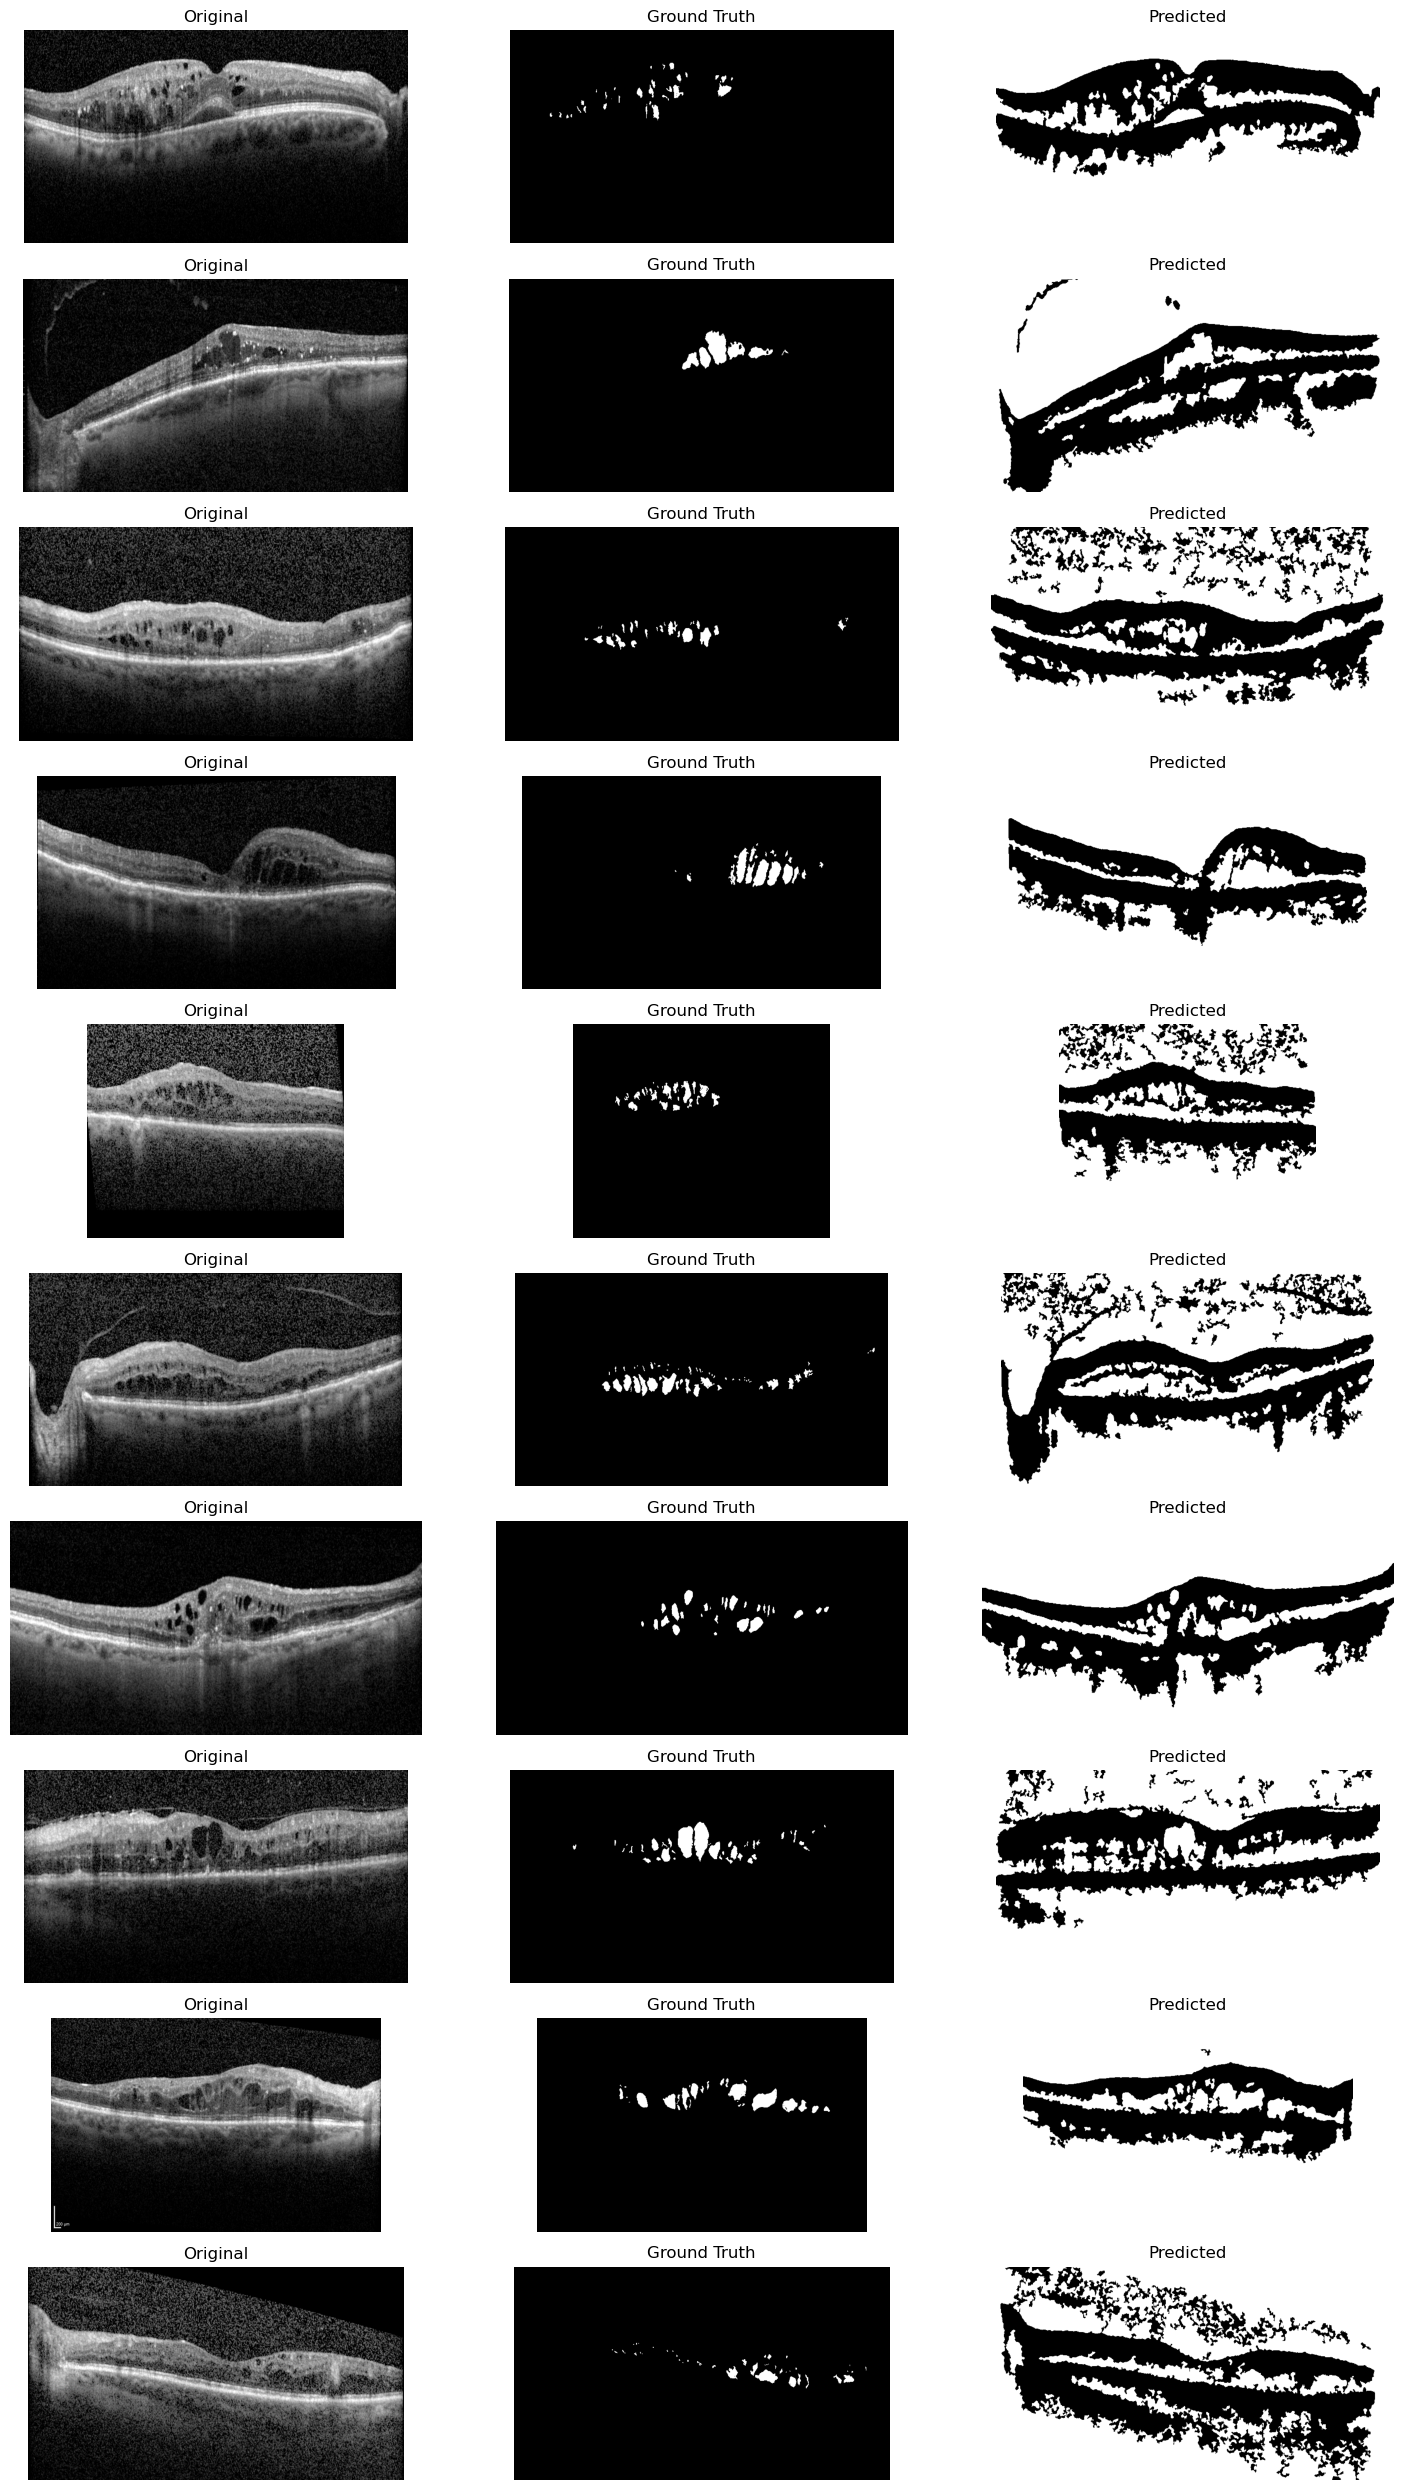

In [8]:
# Step 5: Visualization
# -----------------------------------------------------
print("\nDisplaying all segmentations...")

n = len(images)
plt.figure(figsize=(15, n*2.5))
for i, img_path in enumerate(images):
    fname = os.path.basename(img_path).split('.')[0]
    mask_path = next((m for m in masks if os.path.basename(m).startswith(fname)), None)
    if mask_path is None: continue

    img = cv2.imread(img_path, 0)
    gt = cv2.imread(mask_path, 0)

    # Apply the same segmentation
    eq = exposure.equalize_adapthist(img)
    blur = cv2.medianBlur((eq*255).astype('uint8'), 5)
    th = filters.threshold_otsu(blur)
    seg = blur < th
    seg = morphology.remove_small_objects(seg, 50)
    seg = morphology.remove_small_holes(seg, 100)

    plt.subplot(n, 3, 3*i+1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(n, 3, 3*i+2); plt.imshow(gt, cmap='gray'); plt.title("Ground Truth"); plt.axis('off')
    plt.subplot(n, 3, 3*i+3); plt.imshow(seg, cmap='gray'); plt.title("Predicted"); plt.axis('off')

plt.tight_layout()
plt.show()

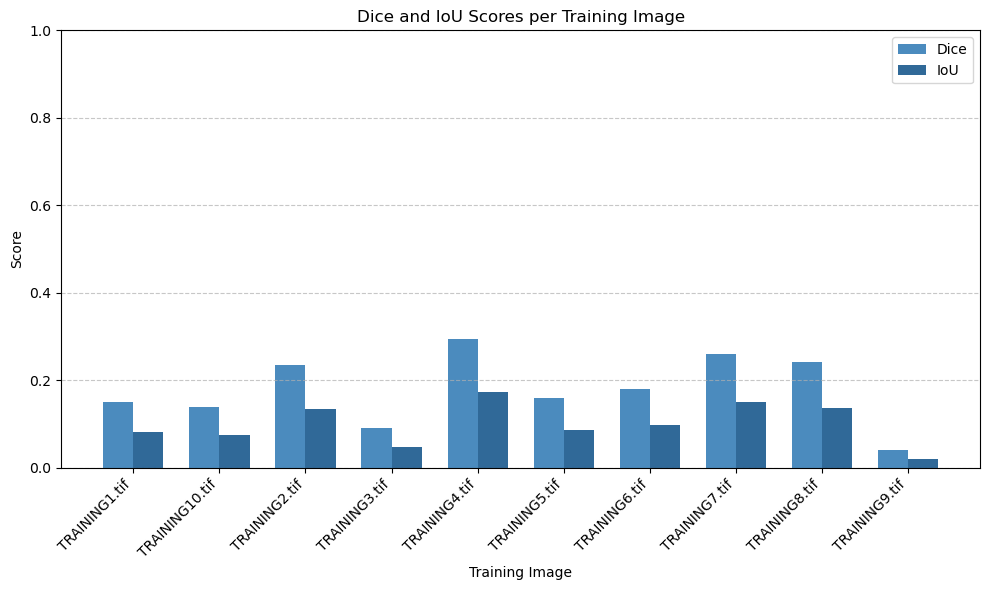

In [12]:
# Step 6: Average Bar Chart
# -----------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# Data from your table
images = [
    "TRAINING1.tif", "TRAINING10.tif", "TRAINING2.tif", "TRAINING3.tif",
    "TRAINING4.tif", "TRAINING5.tif", "TRAINING6.tif", "TRAINING7.tif",
    "TRAINING8.tif", "TRAINING9.tif"
]

dice_scores = [0.149369, 0.137992, 0.235344, 0.089795, 0.295052,
               0.158527, 0.179089, 0.259872, 0.240990, 0.041017]

iou_scores = [0.080713, 0.074109, 0.133365, 0.047008, 0.173057,
              0.086087, 0.098351, 0.149340, 0.137003, 0.020938]

# X positions for each group
x = np.arange(len(images))
width = 0.35  # width of bars

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, dice_scores, width, label='Dice', color='#4B8BBE')
plt.bar(x + width/2, iou_scores, width, label='IoU', color='#306998')

# Customize chart
plt.ylim(0, 1)
plt.title("Dice and IoU Scores per Training Image")
plt.ylabel("Score")
plt.xlabel("Training Image")
plt.xticks(x, images, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

